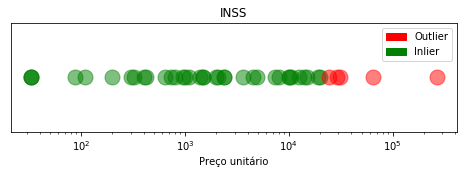

In [29]:
# %load find_outliers.py
from csver import CSVer
from plotter import Plotter
from IPython.display import display
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

pd.options.mode.chained_assignment = None

class FindOutliers:

    def __init__(self, training_data):
        self.training_data = training_data

    def train_1d(self):
        self.lof = LocalOutlierFactor()
      
        data_1d = self.training_data.reshape(-1, 1)
        self.lof_labels = self.lof.fit_predict(data_1d)
        return self.lof_labels
    
    def train(self):
        if self.is_data_1d():
            return self.train_1d()
        self.lof = LocalOutlierFactor()
    
    def is_data_1d(self):
        dimension = self.training_data.ndim
        return dimension == 1
    
    def plot_inliers_outliers_1d(self, item, data, labels):
        inliers = data[labels == 1]
        outliers = data[labels == -1]
        
        plt.figure(figsize=(8, 2))
        plt.plot(inliers, np.zeros_like(inliers), 'g.', markersize = 30, alpha = 0.5)
        plt.plot(outliers, np.zeros_like(outliers), 'r.', markersize = 30, alpha = 0.5)
        plt.xscale('log')
        plt.xlabel('Preço unitário')
        red_patch = mpatches.Patch(color='red', label='Outlier')
        green_patch = mpatches.Patch(color='green', label='Inlier')
        plt.legend(handles=[red_patch, green_patch])
        plt.title(item)
        plt.yticks([])
        plt.show()
        
    def get_xy(self, data, price_column):
        return (data['Data'].values,
                data[price_column].values)
        
    def plot_inliers_outliers(self, data, labels, price_column):
        if self.is_data_1d():
            return self.plot_inliers_outliers_1d(data, labels)
        
        inliers = data[labels == 1]
        outliers = data[labels == -1]
        
        x1, y1 = self.get_xy(outliers, price_column)
        x2, y2 = self.get_xy(inliers, price_column)

        fig = plt.figure()
        plotter = Plotter()

        red_patch = mpatches.Patch(color='red', label='Solicitado')
        green_patch = mpatches.Patch(color='green', label='Aprovado')
        plt.legend(handles=[red_patch, green_patch])

        plotter.plot_log_along_time(x1, y1, '.r', figure=fig)
        plotter.plot_log_along_time(x2, y2, '.g', 'Data (dia/mes/ano)',
                                    'Custo Unitário (R$)', item,
                                    figure=fig)
        plotter.show()
    
    def find_outliers_by_price_only(self, prices):
        find_outliers = FindOutliers(prices)
        pred = find_outliers.train()
        return (prices, pred)
    
    def find_outliers_price_data(self, data, price_column):
        xy = data[['Data', price_column]]
        xy['Data'] = CSVer.get_date_axis_from_array(None, xy.Data)
        
        lof = LocalOutlierFactor()
        labels = lof.fit_predict(xy)
        return (xy, labels)
    

csv_names = ['aprovado_small.csv']
csver = CSVer(csv_names)

while True:
    
    item = csver.get_random_item('Item')
    rows = csver.filter_column_by_value('Item', item)
    if len(rows) < 25:
        continue
    
    fo = FindOutliers(rows)
    rows = csver.filter_column_by_value('Item', item)
    prices = rows['ValorUnitarioAprovado'].values
    
    data, labels = fo.find_outliers_by_price_only(prices)
    fo.plot_inliers_outliers_1d(item, data, labels)
    
    # plotter = Plotter()
    # plotter.plot_histogram(prices, 'Price range', 'Frequency', item)
    break